In [118]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import math

## Helper functions

In [204]:
def minus_time(t1, t2):
    a = datetime.timedelta(hours=t1.hour, minutes=t1.minute, seconds=t1.second)
    b = datetime.timedelta(hours=t2.hour, minutes=t2.minute, seconds=t2.second)
    return a - b
    
def mealtime(time_in, variability_in_mins):
    mu = datetime.timedelta(hours=time_in.hour, minutes=time_in.minute).total_seconds()
    sigma = variability_in_mins * 60 / 5
    meal_time_s = np.random.normal(mu, sigma)
    h = int(math.floor(meal_time_s / (60 * 60)))
    m = int(math.floor((meal_time_s - h * 60 * 60)/60))
    s = int(math.floor(meal_time_s - h * 60 * 60 - m * 60))
    meal_time = datetime.time(hour=h, minute=m, second=s)
    return meal_time
    
def add_daily_scatter(df, date_to_plot, ax):
    day_df = df.loc[df['date'] == date_to_plot]
    meal_times = np.asarray([datetime.time(hour=8, minute=0), 
                  datetime.time(hour=12, minute=30), 
                  datetime.time(hour=18, minute=30), 
                  datetime.time(hour=23, minute=0)])
    meal_variability_mins = np.asarray([30, 60, 90, 120])
    latest_available_time = day_df['time'].iloc[0]
    meal_variability_mins = meal_variability_mins[meal_times < latest_available_time].tolist()
    meal_times = meal_times[meal_times < latest_available_time].tolist()
    
    ts = [mealtime(t, r) for (t, r) in zip(meal_times, meal_variability_mins)]
    closest_ts = [day_df['time'][((day_df['time'].apply(lambda x: minus_time(x,t))).abs().argsort()[:1])] for t in ts]
    mus = [day_df.loc[day_df['time'] == t]['BG, mmoll-1'] for t in closest_ts]
    readings = [np.around(np.random.normal(mu, 0.05)) for mu in mus]
    ax.scatter(closest_ts, readings)
    

def plot_daily_BG(df, date_to_plot):
    ax = df.loc[df['date'] == date_to_plot].set_index(df.loc[df['date'] == date_to_plot]['time'])['BG, mmoll-1'].plot()
    ax.set_ylabel('BG, mmoll-1')
    ax.set_xlabel('Time')
    ax.set_ylim((2.0, 18.0))
    t = [datetime.time(hour=4*x) for x in range(6)]
    t.append(datetime.time(hour=23, minute=59))
    ax.set_xticks(t)
    ax.axhspan(2.0, 3.5, alpha=0.5, color='r')
    ax.axhspan(12.0, 18.0, alpha=0.5, color='r')
    ax.axhspan(8.0, 12.0, alpha=0.5, color='orange')
    add_daily_scatter(df, date_to_plot,  ax)
    
def lastWday(adate, w):
    MON, TUE, WED, THU, FRI, SAT, SUN = range(7)
    """Mon:w=0, Sun:w=6"""
    delta = (adate.weekday() + 6 - w) % 7 + 1
    return adate - datetime.timedelta(days=delta)

## Data import and munging

In [163]:
df = pd.read_csv('./FormattedBGReading.csv', 
                header=None, 
                usecols=[1,2,3,4],
                names=['datetime', 'reading1', 'reading2', 'readingtype'],
                #dtype={'datetime':str, 'reading1':np.float64, 'reading2':np.float64, 'readingtype':np.float64}
                parse_dates=['datetime']
                )
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H.%M.%S')
df['time'] = df['datetime'].dt.time
df['date'] = df['datetime'].dt.date
df['BG, mmoll-1'] = (df['reading1']/18.0).round(1)
df.set_index(df['datetime'], inplace=True)
df.head()

,datetime,reading1,reading2,readingtype,time,date,"BG, mmoll-1"
datetime,,,,,,,
2018-07-23 13:54:30,2018-07-23 13:54:30,157.0,157.0,5,13:54:30,2018-07-23,8.7
2018-07-23 13:53:30,2018-07-23 13:53:30,156.0,156.0,5,13:53:30,2018-07-23,8.7
2018-07-23 13:52:30,2018-07-23 13:52:30,155.0,155.0,5,13:52:30,2018-07-23,8.6
2018-07-23 13:51:30,2018-07-23 13:51:30,154.0,154.0,5,13:51:30,2018-07-23,8.6
2018-07-23 13:50:30,2018-07-23 13:50:30,152.0,152.0,5,13:50:30,2018-07-23,8.4


## Today's BGs

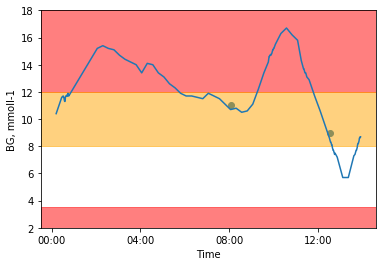

In [196]:
plot_daily_BG(df, datetime.date.today())


## This week's BGs

2018-07-22


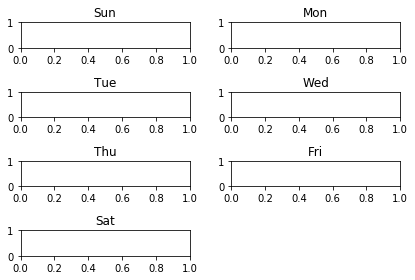

In [222]:
sunday = lastWday(datetime.date.today(), 6)
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

fig2, ax2 = plt.subplots(4,2)
for didx in range(7):
    date = datetime.date.today() - datetime.timedelta(days=didx)
    #print("["+str(int(math.floor(didx/2)))+", "+str(didx % 2)+"]")
    ax2[int(math.floor(didx/2)), didx % 2].set_title(weekdays[didx])
ax2[-1,1].set_visible(False)
plt.tight_layout()